In [3]:
# ── A. Imports & Reproducibility ────────────────────────────────────────────────
import os, copy
import csv                                                  # For result logging :contentReference[oaicite:0]{index=0}
import random                                               # For seeding :contentReference[oaicite:1]{index=1}
import numpy as np                                          # For numeric ops :contentReference[oaicite:2]{index=2}
import torch                                               # Core PyTorch :contentReference[oaicite:3]{index=3}
import torch.nn as nn                                       # Neural-net modules :contentReference[oaicite:4]{index=4}
import torch.nn.functional as F                             # Functional API :contentReference[oaicite:5]{index=5}
import torch.optim as optim                                 # Optimizers :contentReference[oaicite:6]{index=6}
from torch.optim.lr_scheduler import CosineAnnealingLR      # Scheduler :contentReference[oaicite:7]{index=7}
from torch.utils.data import DataLoader, random_split       # Data loaders & splits :contentReference[oaicite:8]{index=8}
import torchvision                                          # Datasets & transforms :contentReference[oaicite:9]{index=9}
import torchvision.transforms as T                          # Transforms :contentReference[oaicite:10]{index=10}
from torch.utils.tensorboard import SummaryWriter           # TensorBoard logging :contentReference[oaicite:11]{index=11}
import matplotlib.pyplot as plt                             # Plotting :contentReference[oaicite:12]{index=12}

In [4]:
# Seed everything for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# ── B. Device ───────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")                             # Confirm GPU vs CPU :contentReference[oaicite:13]{index=13}



# ── C. Data Preparation ─────────────────────────────────────────────────────────
# Transforms
transform_train = T.Compose([
    T.RandomCrop(32, padding=4), T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])


Using device: cuda


In [28]:
import glob, torch, os

def latest_ckpt(dirpath, pattern="last_ckpt_round_*.pth"):
    paths = glob.glob(os.path.join(dirpath, pattern))
    if not paths:
        return None
    paths.sort(key=lambda p: int(p.rsplit("_", 1)[1].split(".")[0]))
    return paths[-1]



def load_checkpoint2(model, optimizer, ckpt_dir, resume=True):
    if not resume:
        print("[Checkpoint] Starting training from scratch.")
        return 1
    ckpt_path = latest_ckpt(ckpt_dir,'last_ckpt_round_*.pth')  #path to ignore first number that is parameter of lamda 
    if ckpt_path is None:
        print("[Checkpoint] No checkpoint found; training from scratch.")
        return 1
    # Load checkpoint tensors onto CPU to preserve RNG state tensor
    ckpt = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optimizer_state'])
    # Restore CPU RNG state
    rng_state = ckpt['rng_state']
    if rng_state.device.type != 'cpu':
        rng_state = rng_state.cpu()
    torch.set_rng_state(rng_state)
    print(f"[Checkpoint] Resumed from round {ckpt['round']} (loaded {os.path.basename(ckpt_path)})")
    return ckpt['round'] + 1


def save_checkpoint(model, optimizer, round_num, ckpt_dir,personalized_par_string="", is_best=False):
    print(f"[Checkpoint] Saving round {round_num}...")
    state = {
        'round': round_num,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'rng_state': torch.get_rng_state(),
    }
    fname = f"{'best' if is_best else 'last'}_ckpt_{personalized_par_string}_{round_num}.pth"
    if is_best:
        torch.save(model.state_dict(), os.path.join(ckpt_dir,fname))
    else:
            torch.save(state, os.path.join(ckpt_dir, fname))

    print(f"[Checkpoint] Done saving to {fname}")

    # for existing in os.listdir(ckpt_dir):
    #     existing_path = os.path.join(ckpt_dir, existing)
    #     if (
    #         existing.endswith('.pth')
    #         and existing != fname
    #         and 'best' not in existing
    #     ):
    #         os.remove(existing_path)
    #         print(f"  Deleted: {existing}")






# def load_checkpoint(model, optimizer, ckpt_dir, resume=True):
#     if not resume:
#         print("[Checkpoint] Starting training from scratch.")
#         return 1
#     ckpt_path = latest_ckpt(ckpt_dir,'last_ckpt_round_lambda_\d_*.pth')  #path to ignore first number that is parameter of lamda 
#     if ckpt_path is None:
#         print("[Checkpoint] No checkpoint found; training from scratch.")
#         return 1
#     # Load checkpoint tensors onto CPU to preserve RNG state tensor
#     ckpt = torch.load(ckpt_path, map_location='cpu')
#     model.load_state_dict(ckpt['model_state'])
#     optimizer.load_state_dict(ckpt['optimizer_state'])
#     # Restore CPU RNG state
#     rng_state = ckpt['rng_state']
#     if rng_state.device.type != 'cpu':
#         rng_state = rng_state.cpu()
#     torch.set_rng_state(rng_state)
#     print(f"[Checkpoint] Resumed from round {ckpt['round']} (loaded {os.path.basename(ckpt_path)})")
#     return ckpt['round'] + 1





In [29]:
# ── C. Data Preparation ─────────────────────────────────────────────────────────
# Transforms (as before)…

# Download full CIFAR‑100 training set
full_train = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train
)

# 1) Centralized validation split
val_size   = 5000
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

# ── C.1 Build validation loader ───────────────────────────────
BS_VAL = 256
val_loader = DataLoader(
    val_dataset,
    batch_size=BS_VAL,
    shuffle=False,
    num_workers=2
)


# 2) IID sharding of the remaining train_dataset into K=100 clients
K = 100
base = train_size // K
sizes = [base] * (K - 1) + [train_size - base * (K - 1)]
shards = random_split(
    train_dataset,
    sizes,
    generator=torch.Generator().manual_seed(seed)
    )


# 3) Global test set (unchanged)
test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test
)

bs_test = 256
test_loader = DataLoader(
    test_dataset, batch_size=bs_test, shuffle=False, num_workers=2
)

# 4) (Later) you can build per-client loaders:
# client_loaders = [
#     DataLoader(shards[i], batch_size=bs, shuffle=True, num_workers=2)
#     for i in range(K)
# ]

"la zanzara concordo"

'la zanzara concordo'

In [30]:
# ── D. Model Definition ─────────────────────────────────────────────────────────
class LELeNetCIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*8*8, 384)
        self.fc2   = nn.Linear(384, 192)
        self.fc3   = nn.Linear(192, 100)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x))
        return self.fc3(x)

In [31]:
# ── E. Utilities: Train/Eval & Checkpointing ────────────────────────────────────
def train_one_epoch(model, optimizer, criterion, loader):
    model.train()
    running_loss = correct = total = 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward(); optimizer.step()
        running_loss += loss.item()*imgs.size(0)
        correct += out.argmax(1).eq(lbls).sum().item()
        total += lbls.size(0)
    return running_loss/total, correct/total

def eval_model(model, criterion, loader):
    model.eval()
    running_loss = correct = total = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs); loss = criterion(out, lbls)
            running_loss += loss.item()*imgs.size(0)
            correct += out.argmax(1).eq(lbls).sum().item()
            total += lbls.size(0)
    return running_loss/total, correct/total


def sample_clients_dirichlet(K, m, gamma, rng=None):
    """
    Sample m clients out of K with probabilities drawn from a Dirichlet(gamma) distribution.
    Returns:
      selected: list of client indices
      p:      numpy array of length K with the sampling probabilities
    """
    if gamma == 'uniform':
        # fallback to uniform
        p = np.ones(K) / K
    else:
        # draw a single Dirichlet vector
        alpha = np.ones(K) * gamma
        p = np.random.default_rng(rng).dirichlet(alpha)
    # now sample m unique clients according to p
    selected = np.random.default_rng(rng).choice(
        np.arange(K), size=m, replace=False, p=p
    )
    return selected.tolist(), p



In [32]:
import os
import csv
import copy

def run_federated_training(
    gamma,
    global_model,
    optimizer,
    criterion,
    client_loaders,
    val_loader,
    test_loader,
    shards,
    K=100, C=0.1, J=4, ROUNDS=2000,
    BS=128, CKPT_DIR="./fl_checkpoints"
):
    # Prepare CSV logging path per gamma
    csv_path = f'./fedavg_results_gamma_{gamma}.csv'
    if not os.path.exists(csv_path):
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['round', 'val_loss', 'val_acc', 'test_loss', 'test_acc'])

    # TensorBoard writer per gamma
    from torch.utils.tensorboard import SummaryWriter
    log_dir = f"./logs/FedAvg_gamma{gamma}_bs{BS}"
    tb_writer = SummaryWriter(log_dir=log_dir)

    #start_round = load_checkpoint2(global_model, optimizer, CKPT_DIR, resume=RESUME)
    best_accuracy = 0

    print(f"[Training] Starting gamma = {gamma} from round {0} to {ROUNDS}")

    best_model_state = None 
    best_round=1

    for rnd in range(1, ROUNDS + 1):
        m = max(1, int(C * K))
        selected, _ = sample_clients_dirichlet(K, m, gamma=gamma)

        local_states, sizes = [], []
        for i in selected:
            client_model = copy.deepcopy(global_model)
            client_model.train()
            client_opt = optim.SGD(client_model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)

            for _ in range(J):
                train_one_epoch(client_model, client_opt, criterion, client_loaders[i])
            local_states.append(client_model.state_dict())
            sizes.append(len(shards[i]))

        total_size = sum(sizes)
        new_state = {
            k: sum((sizes[j] / total_size) * local_states[j][k] for j in range(len(sizes)))
            for k in global_model.state_dict()
        }
        global_model.load_state_dict(new_state)

        val_loss, val_acc = eval_model(global_model, criterion, val_loader)
        test_loss, test_acc = eval_model(global_model, criterion, test_loader)

        with open(csv_path, 'a', newline='') as f:
            csv.writer(f).writerow([
                rnd,
                f"{val_loss:.4f}", f"{val_acc:.4f}",
                f"{test_loss:.4f}", f"{test_acc:.4f}"
            ])

        tb_writer.add_scalar('Accuracy/Validation', val_acc, rnd)
        tb_writer.add_scalar('Loss/Validation', val_loss, rnd)
        tb_writer.add_scalar('Accuracy/Test', test_acc, rnd)
        tb_writer.add_scalar('Loss/Test', test_loss, rnd)
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_state = copy.deepcopy(global_model.state_dict())
            best_round=rnd
            

        # if val_acc > best_accuracy:
        #     best_accuracy = val_acc
        #     save_checkpoint(global_model, optimizer, rnd, CKPT_DIR, is_best=True)

        # if rnd % 10 == 0 or rnd == 1:
        #     print(f"Checkpointing round {rnd} (gamma={gamma})")
        #     save_checkpoint(global_model, optimizer, rnd, CKPT_DIR, is_best=False)
        #     print(f"Round {rnd}/{ROUNDS} | Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
    

    if best_model_state is not None:
        global_model.load_state_dict(best_model_state)  # Load best weights back into the model
        save_checkpoint(
            model=global_model,
            optimizer=optimizer,
            round_num=best_round,
            ckpt_dir=CKPT_DIR,
            personalized_par_string=f"gamma_{gamma}",
            is_best=True
        )
    # if best_model_state is not None:
    #     model_path = os.path.join(CKPT_DIR, f"best_model_gamma_{gamma}.pth")
    #     torch.save(best_model_state, model_path)
    #     print(f"[Saved] Best model for gamma={gamma} with Val Acc = {best_accuracy:.4f} → {model_path}")


In [34]:

# ── A. Mount Google Drive ─────────────────────────────────────────────────────
import os

try:
    from google.colab import drive
    # If import succeeds, we are likely in Colab
    IN_COLAB = True
except ImportError:
    # If import fails, we are likely not in Colab
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')
    CKPT_DIR = '/content/drive/MyDrive/fl_checkpoints'
else:
    CKPT_DIR = './fl_checkpoints'
os.makedirs(CKPT_DIR, exist_ok=True)




# Set this to True to resume from the last checkpoint; False to start from scratch
RESUME = True



# ── A. FedAvg Hyperparameters ───────────────────────────────────────────────────
# Fixed FL parameters
K      = 100      # total clients
C      = 0.1      # fraction of clients sampled per round
J      = 4        # local epochs per client
ROUNDS = 2000  #2000     # total communication rounds

# Optimizer hyperparameters (constant, no schedule)
LR     = 0.01     # fixed learning rate
WD     = 1e-4     # weight decay
BS     = 128      # per-client batch size

#gamma value for dirichlet client selection
GAMMA = 0.01 #try later with 0.1 and 1.0 and 'uniform'

# ── Instantiate TensorBoard writer ──────────────────────────────────────────────
from torch.utils.tensorboard import SummaryWriter
log_dir   = f"./logs/FedAvg_lr{LR}_wd{WD}_bs{BS}"
tb_writer = SummaryWriter(log_dir=log_dir)



# Before your FedAvg loop: Instantiate the global model, loss, and client loaders once

# Instantiate model, optimizer, loss, and client loaders
global_model   = LELeNetCIFAR().to(device)
optimizer      = optim.SGD(global_model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
criterion      = nn.CrossEntropyLoss()
client_loaders = [
    DataLoader(shards[i], batch_size=BS, shuffle=True, num_workers=2)
    for i in range(K)
]





# Load checkpoint (or start at 1)
#start_round = load_checkpoint2(global_model, optimizer, CKPT_DIR, resume=RESUME)




""" gammas=[0.1,0.2,0.3,0.6,1,10,100]
for i in range(gammas):
    best_accuracy=0
    GAMMA=gammas[i]

    print(f"[Training] Beginning training from round {start_round} to {ROUNDS} for gamma = {GAMMA}")

    # ── C. FedAvg Training Loop ─────────────────────────────────────────────────────
    for rnd in range(start_round, ROUNDS + 1):
        # 1) Sample clients
        #print(f"[Round {rnd}] Sampling {int(C*K)} clients...")
        m = max(1, int(C * K))      # → 10 clients per round when K=100, C=0.1
        selected, p = sample_clients_dirichlet(K, m, gamma=GAMMA)
        #sampling_probs_history.append(p)

        local_states, sizes = [], []
        for i in selected:
            # 2a) Copy global model
            client_model = copy.deepcopy(global_model)
            client_model.train()
            client_opt = optim.SGD(client_model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)

            # 2b) Local training for J epochs
            for _ in range(J):
                loss, acc = train_one_epoch(client_model, client_opt, criterion, client_loaders[i])
            local_states.append(client_model.state_dict())
            sizes.append(len(shards[i]))



        # 3) Weighted aggregation
        total_size = sum(sizes)
        new_state = {}
        for k in global_model.state_dict():
            new_state[k] = sum((sizes[j] / total_size) * local_states[j][k] for j in range(len(sizes)))
        global_model.load_state_dict(new_state)

        # 4) Global evaluation
        # 4a) Validation evaluation
        val_loss, val_acc = eval_model(global_model, criterion, val_loader)

        # 4b) Test evaluation
        test_loss, test_acc = eval_model(global_model, criterion, test_loader)

        # 5) Checkpoint & logging
        with open(csv_path, 'a', newline='') as f:
            csv.writer(f).writerow([rnd,
                                    f"{val_loss:.4f}", f"{val_acc:.4f}",
                                    f"{test_loss:.4f}", f"{test_acc:.4f}"])


        # 6) TensorBoard logging
        tb_writer.add_scalar('Accuracy/Validation', val_acc, rnd)
        tb_writer.add_scalar('Loss/Validation',    val_loss, rnd)
        tb_writer.add_scalar('Accuracy/Test',       test_acc, rnd)
        tb_writer.add_scalar('Loss/Test',           test_loss, rnd)

        if val_acc>best_accuracy:
            val_acc=best_accuracy
            save_checkpoint(global_model, optimizer, rnd, CKPT_DIR, is_best=True)





        if rnd % 10 == 0 or rnd == 1:
            #diocan sono 7 MB l uno, ne salvo solo qualcuno
            print(f"Saving checkpoint {rnd} on Google Drive")
            save_checkpoint(global_model, optimizer, rnd, CKPT_DIR, is_best=False)

            print(f"Round {rnd}/{ROUNDS} → "
                f"Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}") """


gammas = [0.1, 0.5, 1, 10, 100]


#gamma value for dirichlet client selection
GAMMA = 0.01 #try later with 0.1 and 1.0 and 'uniform'

for gamma in gammas:
    # Reinitialize model and optimizer per gamma
    model = LELeNetCIFAR().to(device)
    opt = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
    loss_fn = nn.CrossEntropyLoss()

    run_federated_training(
        gamma=gamma,
        global_model=model,
        optimizer=opt,
        criterion=loss_fn,
        client_loaders=client_loaders,
        val_loader=val_loader,
        test_loader=test_loader,
        shards=shards,
        CKPT_DIR=CKPT_DIR,
        K=K,C=C,J=J,ROUNDS=ROUNDS,BS=BS
    )


[Training] Starting gamma = 0.1 from round 0 to 2000
[Checkpoint] Saving round 1752...
[Checkpoint] Done saving to best_ckpt_gamma_0.1_1752.pth
[Training] Starting gamma = 0.5 from round 0 to 2000
[Checkpoint] Saving round 1947...
[Checkpoint] Done saving to best_ckpt_gamma_0.5_1947.pth
[Training] Starting gamma = 1 from round 0 to 2000
[Checkpoint] Saving round 1958...
[Checkpoint] Done saving to best_ckpt_gamma_1_1958.pth
[Training] Starting gamma = 10 from round 0 to 2000
[Checkpoint] Saving round 1945...
[Checkpoint] Done saving to best_ckpt_gamma_10_1945.pth
[Training] Starting gamma = 100 from round 0 to 2000


KeyboardInterrupt: 

Gamma 0.01: Max Test Acc = 0.4493
Gamma 0.1: Max Test Acc = 0.4538
Gamma 0.5: Max Test Acc = 0.4512
Gamma 1: Max Test Acc = 0.4554
Gamma 10: Max Test Acc = 0.4454


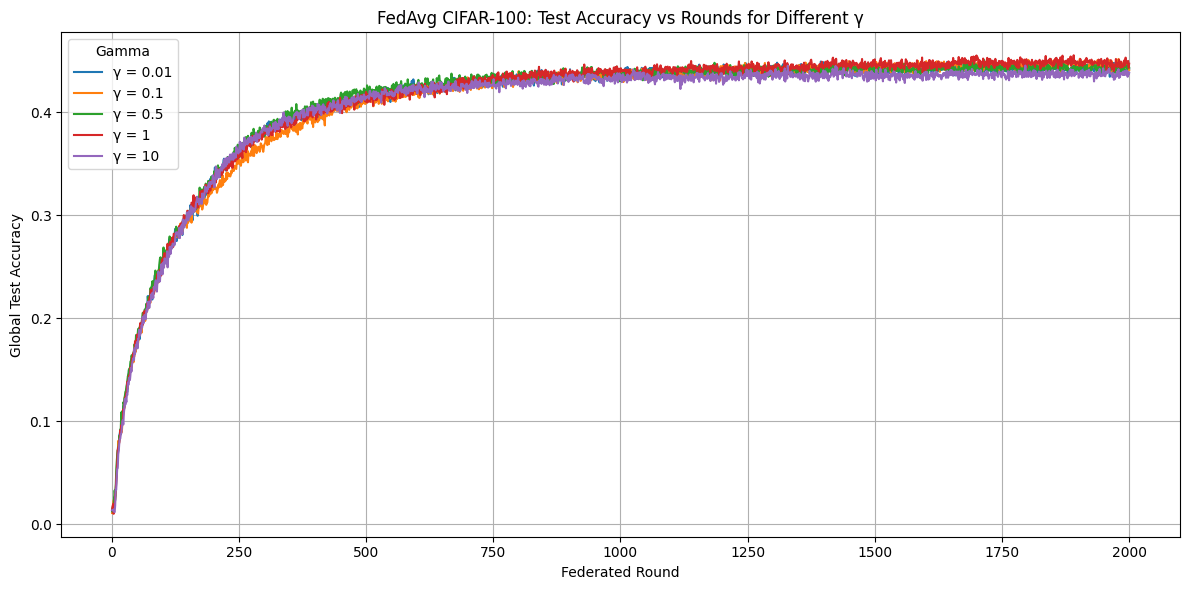

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# List of gamma values and corresponding file names
gammas = [0.01,0.1, 0.5, 1, 10]
base_path = './fedavg_results_gamma_{}.csv'

# Set up the plot
plt.figure(figsize=(12, 6))

# Load and plot each CSV
for gamma in gammas:
    file_path = base_path.format(gamma)
    df = pd.read_csv(file_path)
    
    plt.plot(df['round'], df['test_acc'], label=f'γ = {gamma}')
    print(f"Gamma {gamma}: Max Test Acc = {df['test_acc'].max():.4f}")


# Configure plot
plt.xlabel('Federated Round')
plt.ylabel('Global Test Accuracy')
plt.title('FedAvg CIFAR-100: Test Accuracy vs Rounds for Different γ')
plt.grid(True)
plt.legend(title="Gamma")
plt.tight_layout()
plt.show()
